In [ ]:
import pickle
import random
from sklearn.linear_model import LinearRegression

import networkx as nx
import numpy as np

from agents import misinfoAgent
from misinfo_functions import (
    generate_params_dict,
    step_params_dict,
    calc_energy,
    acceptance_proba,
    make_agent_info_dict,
    update_agent_info,
)
from utilities import markov_update_log, make_configuration_model_graph


def run_agent_simulation(N_AGENTS, params_dict):
    """
    Given a number of agents & parameters for constructing the simulation,
    run a 100-round simulation of belief updating w/ Bayesian agents.
    
    Returns info on each agent's parameters, sharing for each agent each round, and centrality info for each agent.
    """
    agents = []

    for i in range(N_AGENTS):
        agent = misinfoAgent(
            agent_id=i,
            neighbors={},
            forcefulness=np.log(
                np.random.beta(params_dict["B1_START_FO"], params_dict["B2_START_FO"])
            ),
            share_propensity=np.log(
                np.random.beta(params_dict["B1_START_SP"], params_dict["B2_START_SP"])
            ),
            misinfo_belief=np.log(
                np.random.beta(params_dict["B1_START_MB"], params_dict["B2_START_MB"])
            ),
            trust_stability=np.log(
                np.random.beta(params_dict["B1_START_TS"], params_dict["B2_START_TS"])
            ),
        )
        agents.append(agent)

    # G, agents = make_er_graph(0.05, N_AGENTS, agents)
    # G, agents = make_configuration_model_graph(N_AGENTS, 2.5, agents, params_dict)
    centrality = sorted(
        [(k, v) for k, v in nx.closeness_centrality(G).items()], key=lambda b: b[0]
    )

    centrality = np.array([c[1] for c in centrality]).reshape(-1, 1)
    agent_records = {a.agent_id: {} for a in agents}
    shares = {a.agent_id: {} for a in agents}

    # from multiprocessing import Pool
    # pool = Pool(8)

    for time_step in range(250):
        for agent in agents:
            agent_records[agent.agent_id][time_step] = {
                "neighbor_trust": agent.neighbors,
                "misinfo_belief": agent.misinfo_belief,
                "share_propensity": agent.share_propensity,
            }

        neighbor_beliefs = [
            [(i, agents[i].misinfo_belief) for i in agent.neighbors.keys()]
            for agent in agents
        ]
        neighbor_forcefulness = [
            [agents[i].forcefulness for i in agent.neighbors.keys()] for agent in agents
        ]
        agent_info_dicts = [
            make_agent_info_dict(a, b, f, params_dict)
            for a, b, f in zip(agents, neighbor_beliefs, neighbor_forcefulness)
        ]
        res = map(update_agent_info, agent_info_dicts)
        for r, agent in zip(res, agents):
            agent.neighbors = r["neighbor_trust"]
            agent.misinfo_belief = r["misinfo_belief"]
            agent.share_propensity = r["share_propensity"]
            shares[agent.agent_id][time_step] = r["shares"]

    return agents, shares, centrality


def p_x_y(agents, shares, centrality, alpha):
    """
    For a set of Bayesian agents at the end of a simulation,
    plus their sharing results & centrality metrics, report 
    the loss of the dataset relative to reality
    
    (note that reality is currently somewhat made up)
    alpha is a scaling parameter.
    
    Returns sum of loss fns, each raised to alpha then divided by alpha
    """
    loss = 0.0
    shared = [np.sum([v for v in shares[a.agent_id].values()]) for a in agents]
    shared_by_id = [
        (a.agent_id, np.sum([v for v in shares[a.agent_id].values()])) for a in agents
    ]
    shared_by_id = sorted(shared_by_id, key=lambda b: b[0])
    shared_by_id = [s[1] for s in shared_by_id]
    # find correlation between sharing and centrality,
    # with the assumption that more central nodes share more.
    # we need to get a quantitative measurement for this.
    reg = LinearRegression().fit(centrality, shared)
    centrality_to_n_shared_model = reg.coef_[0]
    centrality_to_n_shared_real = 0.5 # arbitrary guess
    loss += np.abs(centrality_to_n_shared_model - centrality_to_n_shared_real) ** alpha
    
    # find out how much misinfo was shared by the top 1% of misinfo sharers
    # using L1 loss here.
    shared_by_top_one_percent_model = np.sum(
        sorted(shared)[-int(0.01 * len(shared)) :]
    ) / (1 + np.sum(shared))
    shared_by_top_one_percent_real = 0.8 # info from lazer lab twitter metrics
    loss += np.abs(shared_by_top_one_percent_model - shared_by_top_one_percent_real) ** alpha

    # find out how much sharing per capita occurred
    # again using L1 loss
    n_shared_per_capita_model = np.sum(shared) / len(agents)
    n_shared_per_capita_real = 1.0
    loss += np.abs(n_shared_per_capita_model - n_shared_per_capita_real) ** alpha
    
    return loss / alpha
    
    
def G_func(my_ensemble_P, x):
    """
    Get smoothed probability of a simulation outcome x
    given my_ensemble_P, which is an ensemble of simulation outcomes
    generated from the overall distribution.
    """
    # make fancier later? right now assumes constant prior (the horror)
    constant_proba = np.log(0.1) * 10 + np.log(0.01) * 2
    candidates = [np.exp(constant_proba) for tup in my_ensemble_P if tup[1] <= x]
    return np.sum(candidates)
            
# setting up simulation. 
N_AGENTS = 100
ALPHA = 2.5
EPSILON_INIT = 0.5
rnd_info = []

ensemble_P = []
ensemble_E = []

# burn-in period (kind of) - getting ensemble_E, 
# which is the fairly likely set of parameter -> outcome items.
while len(ensemble_E) < 100:
    if len(ensemble_E) % 5 == 0 and len(ensemble_E) != 0:
        print(len(ensemble_E))
    params_dict = generate_params_dict()
    agents, shares, centrality = run_agent_simulation(N_AGENTS, params_dict)
    tup = (params_dict, p_x_y(agents, shares, centrality, ALPHA))
    proba_p = np.exp(-1.0 * tup[1]/ EPSILON_INIT)
    draw = np.random.uniform()
    if draw < proba_p:
        ensemble_E.append(tup)
        # if it's a good draw compared to the overall "background" ensemble,
        # we will likely add it to ensemble_E. 
    ensemble_P.append(tup)
    
# smoothed probabilities for items in ensemble_P
G_result = [G_func(ensemble_P, tup[1]) for tup in ensemble_P]
# the starting "good" ensemble of predictions
ensemble_E = [(tup[0], G_func(ensemble_P, tup[1])) for tup in ensemble_E]
U = np.mean(G_result)

EPSILON = EPSILON_INIT
t = 1
swap_rate = 0
tries = 0
while True:
    # we choose a random item in ensemble_E 
    # and generate a new set of parameters & its simulation outcome.
    # if our new item is better than the item in ensemble E,
    # we swap the old item with the new item w/ high probability.
    chosen_one = random.choice([i for i in range(len(ensemble_E))])   
    particle, u = ensemble_E[chosen_one]
    proposal = generate_params_dict()
    agents, shares, centrality = run_agent_simulation(N_AGENTS, params_dict)
    proba_star = p_x_y(agents, shares, centrality, ALPHA)
    u_star = G_func(ensemble_P, proba_star)
    
    proba_swap = min(1.0, np.exp(-1.0 * (u_star - u)) / np.exp(EPSILON))
    tries += 1
    if np.random.uniform() < proba_swap:
        swap_rate += 1
        ensemble_E[chosen_one] = (proposal, u_star)

    EPSILON = t ** (0.1)
    # we keep doing this until our continuous swap rate
    # drops below a threshold (0.05) - in that case, 
    # we're rejecting most items so we should give up.
    if t % 10 == 0:
        print(swap_rate / tries)
    if t % 1000 == 0:
        # dumps items to file for future analysis.
        pickle.dump(ensemble_E, open('ensemble_E_{}.pkl'.format(str(t)), 'wb'))
    t += 1
    if (swap_rate / tries) < 0.05 and tries > 20:
        break

0.3
0.35
0.36666666666666664
0.3
0.24
0.26666666666666666
0.22857142857142856
0.2625
0.25555555555555554
0.25
0.24545454545454545
0.24166666666666667
0.23076923076923078
0.21428571428571427
0.20666666666666667
0.2125
0.21764705882352942
0.2222222222222222
0.22105263157894736
0.225
0.21904761904761905
0.21818181818181817
0.21304347826086956
0.20833333333333334
0.2
0.19615384615384615
0.18888888888888888
0.19285714285714287
0.1896551724137931
0.19
0.18387096774193548
0.18125
0.1787878787878788
0.17647058823529413
0.18
0.18055555555555555
0.1837837837837838
0.18947368421052632
0.18974358974358974
0.1875
0.18292682926829268
0.18333333333333332
0.18372093023255814
0.18636363636363637
0.18444444444444444
0.18478260869565216
0.18085106382978725
0.17708333333333334
0.17346938775510204
0.174
0.17254901960784313
0.16923076923076924
0.17358490566037735
0.17037037037037037
0.1690909090909091
0.16785714285714284
0.16842105263157894
0.16896551724137931
0.16779661016949152
0.165
0.16393442622950818
0

0.12560706401766003
0.12555066079295155
0.1254945054945055
0.12521929824561404
0.12516411378555797
0.12510917030567686
0.12527233115468409
0.12543478260869564
0.12537960954446856
0.1251082251082251
0.12505399568034556
0.1247844827586207
0.12451612903225806
0.12424892703862661
0.12419700214132762
0.12393162393162394
0.12388059701492538
0.12361702127659574
0.12356687898089172
0.12330508474576271
0.12346723044397463
0.12320675105485232
0.12294736842105262
0.12289915966386554
0.12264150943396226
0.12238493723849372
0.12233820459290187
0.12208333333333334
0.12182952182952184
0.12178423236514523
0.12173913043478261
0.12190082644628099
0.12185567010309278
0.12160493827160494
0.1213552361396304
0.12151639344262295
0.12167689161554192
0.12183673469387755
0.12179226069246436
0.12195121951219512
0.12170385395537525
0.12165991902834009
0.12161616161616162
0.12137096774193548
0.12132796780684105


dict_keys(['B1_NTRUST', 'B2_NTRUST', 'B1_START_MB', 'B2_START_MB', 'B1_START_FO', 'B2_START_FO', 'B1_START_SP', 'B2_START_SP', 'B1_START_TS', 'B2_START_TS', 'NTRUST_THRESHOLD', 'SP_THRESHOLD'])


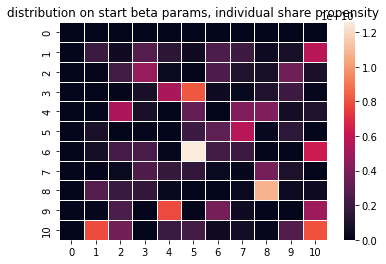

In [5]:
# just some visualizations down here.
import numpy as np
import collections
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
ensemble_Ee = pickle.load(open('ensemble_e_configuration_model/ensemble_E_171900.pkl', 'rb')) # latest param set
print(ensemble_Ee[0][0].keys())
spt_th = collections.Counter([str(e[0]['B1_START_SP']) + '_' + str(e[0]['B2_START_SP']) for e in ensemble_Ee])
a = np.zeros((11, 11))
b = np.zeros((11, 11))
c = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        a[i, j] = spt_th[str(i) + '_' + str(j)] 
        b[i, j] = np.sum([e[1]  for e in ensemble_Ee if e[0]['B1_START_SP'] == i and e[0]['B2_START_SP'] == j])
        c[i, j] = a[i, j] * b[i, j]
plt.title('distribution on start beta params, individual share propensity')
ax = sns.heatmap(c, linewidth=0.5)
plt.show()

dict_keys(['B1_NTRUST', 'B2_NTRUST', 'B1_START_MB', 'B2_START_MB', 'B1_START_FO', 'B2_START_FO', 'B1_START_SP', 'B2_START_SP', 'B1_START_TS', 'B2_START_TS', 'NTRUST_THRESHOLD', 'SP_THRESHOLD'])


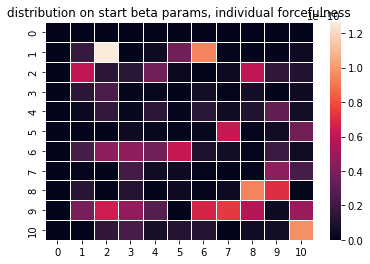

In [6]:
import numpy as np
import collections
import seaborn as sns
ensemble_Ee = pickle.load(open('ensemble_e_configuration_model/ensemble_E_171900.pkl', 'rb'))
print(ensemble_Ee[0][0].keys())
spt_th = collections.Counter([str(e[0]['B1_START_FO']) + '_' + str(e[0]['B2_START_FO']) for e in ensemble_Ee])
a = np.zeros((11, 11))
b = np.zeros((11, 11))
c = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        a[i, j] = spt_th[str(i) + '_' + str(j)] 
        b[i, j] = np.sum([e[1]  for e in ensemble_Ee if e[0]['B1_START_FO'] == i and e[0]['B2_START_FO'] == j])
        c[i, j] = a[i, j] * b[i, j]
plt.title('distribution on start beta params, individual forcefulness')
ax = sns.heatmap(c, linewidth=0.5)
plt.show()

dict_keys(['B1_NTRUST', 'B2_NTRUST', 'B1_START_MB', 'B2_START_MB', 'B1_START_FO', 'B2_START_FO', 'B1_START_SP', 'B2_START_SP', 'B1_START_TS', 'B2_START_TS', 'NTRUST_THRESHOLD', 'SP_THRESHOLD'])


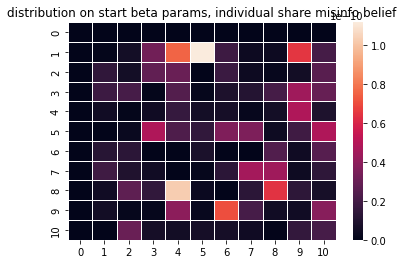

In [7]:
import numpy as np
import collections
import seaborn as sns
ensemble_Ee = pickle.load(open('ensemble_e_configuration_model/ensemble_E_171900.pkl', 'rb'))
print(ensemble_Ee[0][0].keys())
spt_th = collections.Counter([str(e[0]['B1_START_MB']) + '_' + str(e[0]['B2_START_MB']) for e in ensemble_Ee])
a = np.zeros((11, 11))
b = np.zeros((11, 11))
c = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        a[i, j] = spt_th[str(i) + '_' + str(j)] 
        b[i, j] = np.sum([e[1]  for e in ensemble_Ee if e[0]['B1_START_MB'] == i and e[0]['B2_START_MB'] == j])
        c[i, j] = a[i, j] * b[i, j]
plt.title('distribution on start beta params, individual share misinfo belief')
ax = sns.heatmap(c, linewidth=0.5)
plt.show()

dict_keys(['B1_NTRUST', 'B2_NTRUST', 'B1_START_MB', 'B2_START_MB', 'B1_START_FO', 'B2_START_FO', 'B1_START_SP', 'B2_START_SP', 'B1_START_TS', 'B2_START_TS', 'NTRUST_THRESHOLD', 'SP_THRESHOLD'])


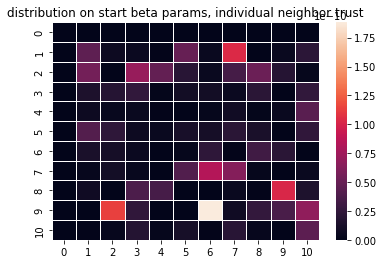

In [8]:
import numpy as np
import collections
import seaborn as sns
ensemble_Ee = pickle.load(open('ensemble_e_configuration_model/ensemble_E_171900.pkl', 'rb'))
print(ensemble_Ee[0][0].keys())
spt_th = collections.Counter([str(e[0]['B1_NTRUST']) + '_' + str(e[0]['B2_NTRUST']) for e in ensemble_Ee])
a = np.zeros((11, 11))
b = np.zeros((11, 11))
c = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        a[i, j] = spt_th[str(i) + '_' + str(j)] 
        b[i, j] = np.sum([e[1]  for e in ensemble_Ee if e[0]['B1_NTRUST'] == i and e[0]['B2_NTRUST'] == j])
        c[i, j] = a[i, j] * b[i, j]
plt.title('distribution on start beta params, individual neighbor trust')
ax = sns.heatmap(c, linewidth=0.5)
plt.show()

(array([26., 18., 19., 20., 22., 19., 15., 21., 18., 22.]),
 array([0.01547743, 0.11323817, 0.21099891, 0.30875964, 0.40652038,
        0.50428112, 0.60204185, 0.69980259, 0.79756333, 0.89532407,
        0.9930848 ]),
 <BarContainer object of 10 artists>)

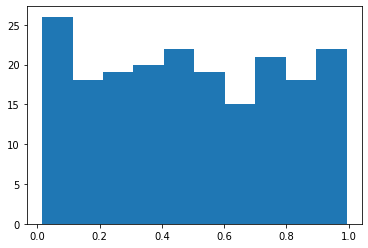

In [4]:
import scipy.stats
lower = 0
upper = 1
mu = 0.5
sigma = 0.1
N = 100000

def truncated_normal():
    return scipy.stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

d = pickle.load(open('rnd_info_30.pkl', 'rb'))
d[0]['params_dict']

{'B1_NTRUST': 4,
 'B2_NTRUST': 8,
 'B1_START_MB': 5,
 'B2_START_MB': 2,
 'B1_START_FO': 10,
 'B2_START_FO': 10,
 'B1_START_SP': 3,
 'B2_START_SP': 5,
 'B1_START_TS': 10,
 'B2_START_TS': 9,
 'NTRUST_THRESHOLD': 0.41937188649018664,
 'SP_THRESHOLD': 0.46966543126877486}

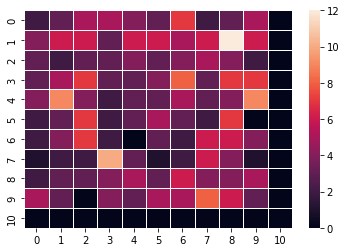

In [101]:
import numpy as np
import collections
import seaborn as sns
d = pickle.load(open('rnd_info_410.pkl', 'rb'))
spt_th = collections.Counter([str(dd['params_dict']['B1_START_MB']) + '_' + str(dd['params_dict']['B2_START_MB']) for dd in d])
a = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        a[i - 1, j - 1] = spt_th[str(i) + '_' + str(j)] 
ax = sns.heatmap(a, linewidth=0.5)
plt.show()


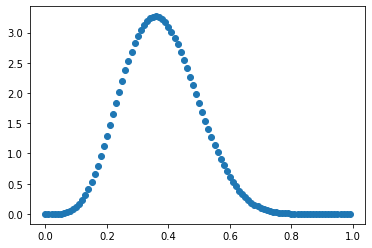

In [113]:
import scipy
xs = [0.01 * i for i in range(100)]
ys = scipy.stats.beta(6, 10).pdf(xs)
plt.scatter(xs, ys)

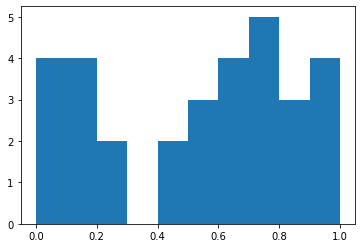

In [54]:
d = pickle.load(open('rnd_info_30.pkl', 'rb'))
spt = [dd['params_dict']['SP_THRESHOLD'] for dd in d]
plt.hist(spt)
plt.show()

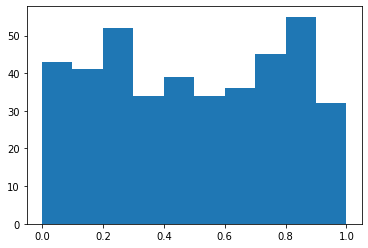

In [100]:
d = pickle.load(open('rnd_info_410.pkl', 'rb'))
spt = [dd['params_dict']['SP_THRESHOLD'] for dd in d]
plt.hist(spt)
plt.show()